In [8]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\A1035501\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 資料格式分析

In [9]:
# Download MIT-BIH Dataset
if os.path.isdir("mitdb"):
    print('You already have the data.')
else:
    wfdb.dl_database('mitdb', 'mitdb')

Created local base download directory: mitdb
Finished downloading files


In [5]:
# Load Data
record = wfdb.rdsamp('mitdb/100',)
annotation = wfdb.rdann('mitdb/100', 'atr')
record

(array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 {'base_date': None,
  'base_time': None,
  'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
  'fs': 360,
  'n_sig': 2,
  'sig_len': 650000,
  'sig_name': ['MLII', 'V5'],
  'units': ['mV', 'mV']})

In [6]:
sym = np.array(annotation.symbol)
sym_index = annotation.sample
print(sym, sym_index)
print(sym.shape[0], sym_index.shape[0])

['+' 'N' 'N' ... 'N' 'N' 'N'] [    18     77    370 ... 649484 649734 649991]
2274 2274


# 資料格式視覺化

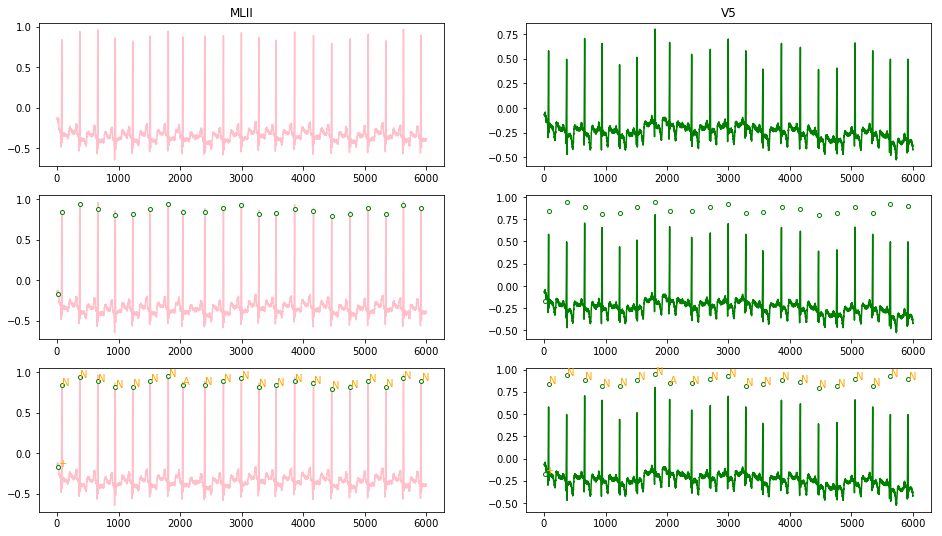

In [7]:
subset_len = 6000
subset_label1 = record[0][:subset_len,0]
subset_label2 = record[0][:subset_len,1]

fig, ax = plt.subplots(ncols=2,nrows=3, figsize=(16, 9))
ax[0][0].set_title('MLII')
ax[0][0].plot(np.arange(0, subset_len), subset_label1, color = 'pink')
ax[1][0].plot(np.arange(0, subset_len), subset_label1, color = 'pink')
ax[2][0].plot(np.arange(0, subset_len), subset_label1, color = 'pink')
ax[0][1].set_title('V5')
ax[0][1].plot(np.arange(0, subset_len), subset_label2, color = 'green')
ax[1][1].plot(np.arange(0, subset_len), subset_label2, color = 'green')
ax[2][1].plot(np.arange(0, subset_len), subset_label2, color = 'green')

for pos, sym in zip(annotation.sample, annotation.symbol):
    if(pos > subset_len):
        break
    ax[1][0].plot(pos, subset_label1[pos], 'go', markersize=4, markerfacecolor='white')
    ax[2][0].plot(pos, subset_label1[pos], 'go', markersize=4, markerfacecolor='white') 
    ax[2][0].text(pos+10, subset_label1[pos], sym, color='orange')
    
    ax[1][1].plot(pos, subset_label1[pos], 'go', markersize=4, markerfacecolor='white')
    ax[2][1].plot(pos, subset_label1[pos], 'go', markersize=4, markerfacecolor='white') 
    ax[2][1].text(pos+10, subset_label1[pos], sym, color='orange')

## 資料分析

In [12]:
all_data_file_name = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', 
             '111', '112', '113', '114', '115', '116', '117', '118', '119',
             '121', '122', '123', '124',
             '200', '201', '202', '203', '205', '207', '208', '209',
             '210', '212', '213', '214', '215', '217', '219',
             '220','221', '222', '223', '228', '230' , '231', '232' , '233', '234']
train_file_name = all_data_file_name[ : 38]
test_file_name = all_data_file_name[38 : ]
print('train files :',len(train_file_name),'\ntest files :', len(test_file_name))

train files : 38 
test files : 10


In [13]:
def describe_annotation(annotation):
    sym = np.array(annotation.symbol)
    sym_index = annotation.sample
    count = {}    
    for i in sym:
        count[i] = count.get(i,0) + 1
    return count

In [14]:
for file_name in train_file_name:
    # Load file
    record = wfdb.rdsamp('mitdb/' + file_name ,)
    annotation = wfdb.rdann('mitdb/' + file_name, 'atr')
    print('file name:', file_name, '             describes:',describe_annotation(annotation))

file name: 100              describes: {'+': 1, 'N': 2239, 'A': 33, 'V': 1}
file name: 101              describes: {'+': 1, 'N': 1860, '~': 4, '|': 4, 'Q': 2, 'A': 3}
file name: 102              describes: {'+': 5, '/': 2028, 'f': 56, 'N': 99, 'V': 4}
file name: 103              describes: {'+': 1, 'N': 2082, '~': 6, 'A': 2}
file name: 104              describes: {'+': 45, '/': 1380, 'f': 666, '~': 37, 'Q': 18, 'N': 163, 'V': 2}
file name: 105              describes: {'+': 1, 'N': 2526, 'V': 41, '~': 88, '|': 30, 'Q': 5}
file name: 106              describes: {'~': 30, '+': 41, 'N': 1507, 'V': 520}
file name: 107              describes: {'+': 1, '/': 2078, 'V': 59, '~': 2}
file name: 108              describes: {'+': 1, 'N': 1739, 'V': 17, 'x': 11, '~': 41, '|': 8, 'F': 2, 'A': 4, 'j': 1}
file name: 109              describes: {'+': 1, 'L': 2492, 'F': 2, 'V': 38, '~': 2}
file name: 111              describes: {'+': 1, 'L': 2123, '~': 8, 'V': 1}
file name: 112              describes: {'

# 處理Data

In [15]:
data = []
symbol_filter = ['N', 'L', 'R', 'a', 'V']
for file_name in all_data_file_name:
    # Load file
    record = wfdb.rdsamp('mitdb/' + file_name ,)
    annotation = wfdb.rdann('mitdb/' + file_name, 'atr')
    print('processing file name:', file_name,'...')
    
    window_size = 100
    label1 = record[0][:,0]
    label2 = record[0][:,1]
    count = 0

    for pos, sym in zip(annotation.sample, annotation.symbol):
        single_data = []
        if(pos > label1.shape[0] - window_size):
            break
        if(pos < window_size):
            continue
        if(not(sym in symbol_filter)):
            continue
        #print(pos, sym)
        single_data.extend(label1[(pos - window_size) : (pos + window_size)])
        single_data.extend(sym)
        #print(single_data)
        count += 1
        # 每筆資料存成一個list
        data.append(single_data)
    print('processing finish, file', file_name, 'has', count, 'samplepoints...')
data = np.array(data)

processing file name: 100 ...
processing finish, file 100 has 2238 samplepoints...
processing file name: 101 ...
processing finish, file 101 has 1859 samplepoints...
processing file name: 102 ...
processing finish, file 102 has 103 samplepoints...
processing file name: 103 ...
processing finish, file 103 has 2082 samplepoints...
processing file name: 104 ...
processing finish, file 104 has 165 samplepoints...
processing file name: 105 ...
processing finish, file 105 has 2567 samplepoints...
processing file name: 106 ...
processing finish, file 106 has 2027 samplepoints...
processing file name: 107 ...
processing finish, file 107 has 59 samplepoints...
processing file name: 108 ...
processing finish, file 108 has 1755 samplepoints...
processing file name: 109 ...
processing finish, file 109 has 2529 samplepoints...
processing file name: 111 ...
processing finish, file 111 has 2124 samplepoints...
processing file name: 112 ...
processing finish, file 112 has 2537 samplepoints...
processi

In [16]:
data.shape

(97637, 201)

# Let's Tensorflow

In [17]:
# shuffle
random.shuffle(data)

In [18]:
def split_data(data):
    split_ratio = 0.7 # 7成當training set, 3成當testing set
    split_point = data.shape[0] * 0.7
    train_data = data[ : int(split_point)]
    test_data = data[ int(split_point) : ]
    print('All data:', data.shape)
    print('Train data:', train_data.shape, 'Test data:', test_data.shape)
    train_X = train_data[:, :-1]
    train_y = train_data[:, -1:]
    test_X = test_data[:, :-1]
    test_y = test_data[:, -1:]
    return train_X, train_y, test_X, test_y
train_X, train_y, test_X, test_y = split_data(data)

All data: (97637, 201)
Train data: (68345, 201) Test data: (29292, 201)


In [19]:
import tensorflow as tf

C:\Users\A1035501\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [20]:
def next_batch(data, batch_size = 100, current_iter = 0):
    return data[current_iter : current_iter + batch_size]

In [21]:
def one_hot_encoding(data):
    temp = []
    for i in data:
        if i == symbol_filter[0]:
            one_hot_list = [1, 0, 0, 0, 0]
        elif i == symbol_filter[1]:
            one_hot_list = [0, 1, 0, 0, 0]
        elif i == symbol_filter[2]:
            one_hot_list = [0, 0, 1, 0, 0]            
        elif i == symbol_filter[3]:
            one_hot_list = [0, 0, 0, 1, 0]       
        elif i == symbol_filter[4]:
            one_hot_list = [0, 0, 0, 0, 1]     
        temp.append(one_hot_list)
    return np.array(temp)
#c = one_hot_encoding(test_y)
#c.shape

In [34]:
BATCH_SIZE = 100 # BATCH的大小，相當於一次處理50個image
TIME_STEP = 10 # 一個LSTM中，輸入序列的長度，image有28行
INPUT_SIZE = 20 # x_i 的向量長度，image有28列
LR = 0.01 # 學習率
NUM_UNITS = 100 # 多少個LTSM單元
ITERATIONS=100000 # 反覆運算次數
N_CLASSES=5 # 輸出大小，0-9十個數位的概率

In [23]:
tf_train_x = tf.placeholder(tf.float32, [None, TIME_STEP * INPUT_SIZE])
# 維度是[BATCH_SIZE，TIME_STEP * INPUT_SIZE]
image = tf.reshape(tf_train_x, [-1, TIME_STEP, INPUT_SIZE])
# 輸入的是二維資料，將其還原為三維，維度是[BATCH_SIZE, TIME_STEP, INPUT_SIZE]
tf_train_y = tf.placeholder(tf.int32, [None, N_CLASSES])

In [24]:
rnn_cell = tf.contrib.rnn.BasicLSTMCell(num_units=NUM_UNITS)
outputs,final_state = tf.nn.dynamic_rnn(
 cell=rnn_cell, # 選擇傳入的cell
 inputs=image, # 傳入的數據
 initial_state=None, # 初始狀態
 dtype=tf.float32, # 資料類型
 time_major=False,
# False: (batch, time step, input); True: (time step, batch, input)，這裡根據image結構選擇False
)
output = tf.layers.dense(inputs=outputs[:, -1, :], units=N_CLASSES)

In [25]:
loss = tf.losses.softmax_cross_entropy(onehot_labels = tf_train_y, logits = output)
train_op = tf.train.AdadeltaOptimizer(LR).minimize(loss)

correct_prediction = tf.equal(tf.argmax(tf_train_y, axis=1), tf.argmax(output, axis = 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [35]:
train_current_iter = 0
test_current_iter = 0
loss_list = []
accurancy_list = []
for step in range(ITERATIONS):
    # next batch
    batch_train_X = next_batch(train_X, BATCH_SIZE, train_current_iter)
    batch_train_y= next_batch(train_y, BATCH_SIZE, train_current_iter)
    batch_train_y = one_hot_encoding(batch_train_y)
    train_current_iter += BATCH_SIZE
    #print(batch_train_X.shape, batch_train_y.shape)
    _, loss_ = sess.run([train_op, loss],{tf_train_x: batch_train_X, tf_train_y: batch_train_y})
    if batch_train_X.shape[0] < BATCH_SIZE:
        train_current_iter = 0
        
    if step % 500 == 0:
        # next batch
        batch_test_X = next_batch(test_X, BATCH_SIZE, test_current_iter)
        batch_test_y= next_batch(test_y, BATCH_SIZE, test_current_iter)
        batch_test_y = one_hot_encoding(batch_test_y)
        test_current_iter += BATCH_SIZE
        
        accuracy_ = sess.run(accuracy, {tf_train_x: batch_test_X, tf_train_y: batch_test_y})
        if batch_test_X.shape[0] < BATCH_SIZE:
            test_current_iter = 0        
        print('train loss: %.4f' %loss_, '|test accuracy: %.2f' % accuracy_)
        loss_list.append(loss_)
        accurancy_list.append(accuracy_)
    

train loss: 0.5142 |test accuracy: 0.81
train loss: 0.4290 |test accuracy: 0.87
train loss: 0.5140 |test accuracy: 0.86
train loss: 0.4676 |test accuracy: 0.77
train loss: 0.5488 |test accuracy: 0.83
train loss: 0.5763 |test accuracy: 0.86
train loss: 0.4373 |test accuracy: 0.85
train loss: 0.4940 |test accuracy: 0.88
train loss: 0.5236 |test accuracy: 0.83
train loss: 0.5604 |test accuracy: 0.78
train loss: 0.3641 |test accuracy: 0.91
train loss: 0.5090 |test accuracy: 0.91
train loss: 0.4770 |test accuracy: 0.85
train loss: 0.3432 |test accuracy: 0.84
train loss: 0.3959 |test accuracy: 0.84
train loss: 0.4196 |test accuracy: 0.89
train loss: 0.4074 |test accuracy: 0.88
train loss: 0.3308 |test accuracy: 0.90
train loss: 0.5970 |test accuracy: 0.83
train loss: 0.3537 |test accuracy: 0.85
train loss: 0.5196 |test accuracy: 0.90
train loss: 0.4701 |test accuracy: 0.90
train loss: 0.4344 |test accuracy: 0.93
train loss: 0.4598 |test accuracy: 0.85
train loss: 0.4918 |test accuracy: 0.89


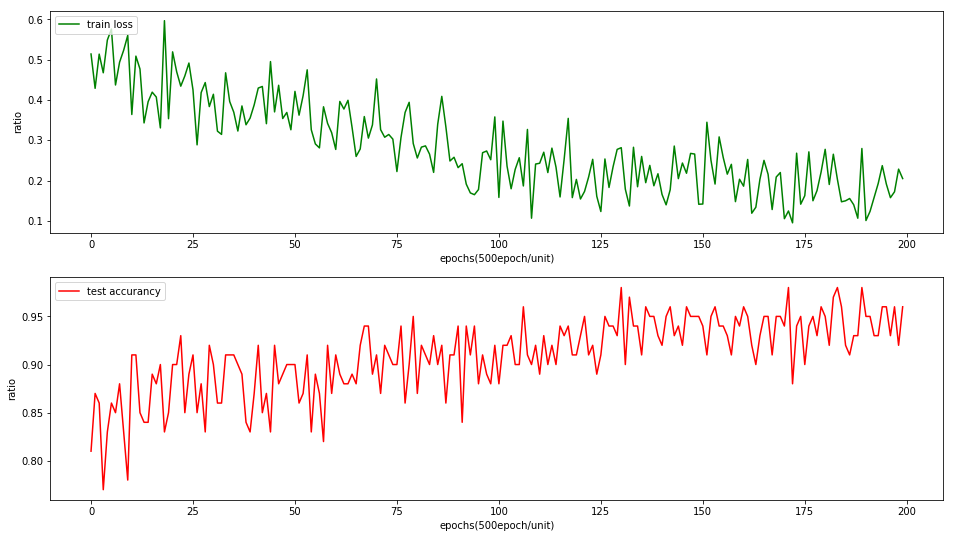

In [64]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 9))
ax[0].plot(loss_list, label = 'train loss', color = 'green')
ax[0].set_ylabel('ratio')
ax[0].set_xlabel('epochs(500epoch/unit)')
ax[0].legend(loc =2)
ax[1].plot(accurancy_list, label = 'test accurancy', color = 'red')
ax[1].set_ylabel('ratio')
ax[1].set_xlabel('epochs(500epoch/unit)')
ax[1].legend(loc =2)